(torch.Size([50]), torch.Size([50]))

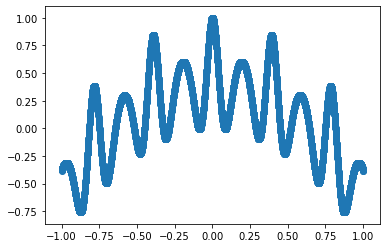

In [100]:
import torch
import matplotlib.pyplot as plt
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.learner import Learner
from fastai2.optimizer import SGD

def func(x):
    return .5-x*x+torch.cos(5*torch.sin(8*x))/2
    

x = 2* torch.rand(10000) -1

y =func(x)

plt.scatter(x,y)

db = DataBlock(get_x = lambda x:x[0], get_y=lambda x:x[1])

data = torch.stack((x,y),dim=1)
data.shape

dls  =db.dataloaders(data,bs=50, device=torch.device('cpu'))

bx, by = dls.one_batch()

bx.shape, by.shape

In [209]:
class ShowChart(Callback):
    
    def __init__(self, dx, dy, figsize=(10,10)):
        self.figsize = figsize
        self.dx = dx
        self.dy = dy
    def after_train(self):
    #def after_batch(self):
        self.update_graph()
    
    
    def begin_fit(self):
        graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
        plt.close()
        self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.update_graph()
        
    def update_graph(self):
        if not hasattr(self, 'graph_ax'): return
        model = self.learn.model    
        prediction = model(self.dx).detach()
        self.graph_ax.clear()
        self.graph_ax.set_ylim(-1.5,1.5)
        self.graph_ax.scatter(self.dx, self.dy, label='actual')
        self.graph_ax.scatter(self.dx,prediction, label = 'pred')
        self.graph_ax.legend(loc='lower left');
        self.graph_out.update(self.graph_ax.figure)
       

In [214]:
class BarModule(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        #self.c = nn.Parameter(torch.linspace(-1,1,n))
        self.c = torch.linspace(-1,1,n)
        self.h = nn.Parameter(torch.randn(n)/10)
        d = .1/(1-n)
        self.w = nn.Parameter( d * torch.ones(n))
    def forward(self, x):
        dist = torch.abs(x[:,None]-self.c)
        res = dist/self.w
        res = res.clamp(-1,1) + 1
        res = res * self.h
        return torch.sum(res, dim=1) 

In [215]:
bm = BarModule(100)
learn = Learner(dls,bm, loss_func=nn.MSELoss(), cbs = ShowChart(x,y))

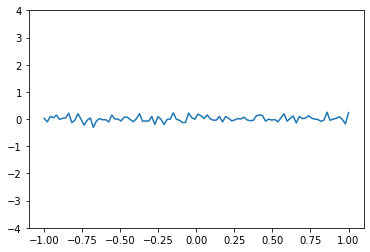

In [216]:
bx = torch.linspace(-1,1,100)
by = bm(bx).detach()
plt.plot(bx, by)
plt.ylim(-4,4)
plt.show()

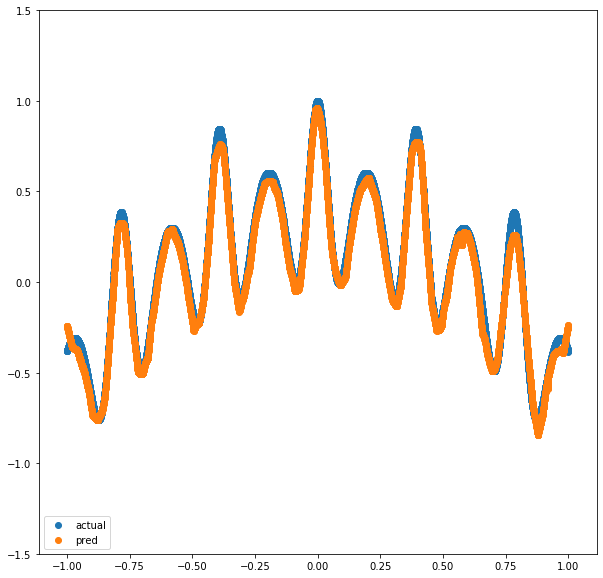

epoch,train_loss,valid_loss,time
0,6.134412,1.028008,00:02
1,0.365335,0.110505,00:02
2,0.077726,0.048096,00:02
3,0.037947,0.026982,00:02
4,0.024276,0.014734,00:02
5,0.012711,0.008653,00:02
6,0.007617,0.005142,00:02
7,0.005992,0.008511,00:02
8,0.003232,0.001712,00:02
9,0.002502,0.002271,00:02


In [217]:
learn.fit(10, lr=1e-3 )